# EN2550 2021: Object Counting on a Convey Belt

In [14]:
### 1.0.1 Import required libraries

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow -----> this is used for google colab coding
%matplotlib inline

### 1.0.2 Let’s load and visualize the template image and the convey belt snapshot at a given time.

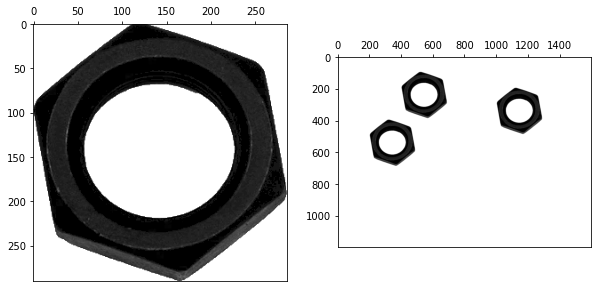

In [16]:
template_im = cv.imread(r'./resources/template.png', cv.IMREAD_GRAYSCALE) # prefix 'r' treats as raw text to the location
belt_im = cv.imread(r'./resources/belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1, 2, figsize=(10,10))

ax[0].imshow(template_im, cmap='gray') # showing image using gray color mapping
ax[0].xaxis.tick_top() # bring the x axis to top
ax[1].imshow(belt_im, cmap='gray')
ax[1].xaxis.tick_top()
plt.show()

## Part 1

#### Brief introduction about thresholding

1. **Simple thresholding**  - *set a same threshold value to the every pixel... If the pixel is less than the threshold it is set as zero. Otherwise set to max value.  __cv.threshold("image in gray scale", "Threshold Value", " maximum value which is assigned to pixel values exceeding the threshold", "Type of thresholding")__... These types are,*

- cv.THRESH_BINARY --> {`max value` for pixels that are greater than threshold and `zero` for others}
- cv.THRESH_BINARY_INV --> {inverse of binary.........}
- cv.THRESH_TRUNC --> {`threshold value` for pixels that are greater than threshold and `original pixel values` for others}
- cv.THRESH_TOZERO --> {`original pixel values` for pixels that are greater than threshold and `zero` for others}
- cv.THRESH_TOZERO_INV --> {inverse of TOZERO.........}

[visualization](https://docs.opencv.org/master/threshold.jpg)

2. **Adaptive Thresholding** - *In the previous section, we used one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel __based on a small region around it__. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination. Thre are two addaptive methods*

- cv.ADAPTIVE_THRESH_MEAN_C --> The threshold value is the mean of the neighbourhood area minus the constant C.
- cv.ADAPTIVE_THRESH_GAUSSIAN_C --> The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C

The blockSize determines the size of the neighbourhood area and C is a constant that is subtracted from the mean or weighted sum of the neighbourhood pixels. __cv.adaptiveThreshold("source image", "maxValue", "adaptiveMethod", "thresholdType", "blockSize", "C")__

3. **Otsu's Binarization** - *Instead of just using threshold value as global thresholding it uses optimal threshold value by looking histogram (If histogram has two main peaks the best threshold is the middle value of two peaks). cv.threshold uses extra flag named as  cv.THRESH_OTSU which choose arbitary threshold value and return it as first output... if the image is noisy we can add filltering brfore that *

### 1.1.1 Otsu’s thresholding

In [17]:
th_t, img_t = cv.threshold(template_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

### 1.1.2 Morphological closing

In [18]:
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

### 1.1.3 Connected component analysis

In [19]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

print(retval_b)
print(" ")
print(stats_b)
print(" ")
print(centroids_b)

4
 
[[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
 
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


### 1.1.4 Contour analysis

In [20]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


contours_temp, hierarchy_temp = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)




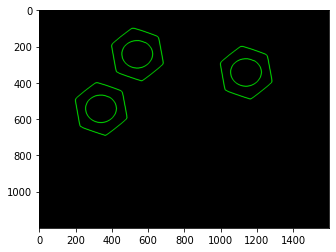

In [21]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

### 1.1.5 Count the number of matching hexagonal nuts in belt.png.

In [22]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
    print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


## Part 2

### 1.2.1 Frame tracking through image moments.

In [23]:
ca = cv.contourArea(contours_b[1])
M = cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

print(cx)
print(" ")
print(cy)

341
 
542


In [24]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

In [25]:
delta_x = 15
object_curr_frame = np.array([cx, cy, ca, count])

movement_of_cx = object_curr_frame[0] - object_prev_frame[0]

if movement_of_cx < delta_x :
    print("Hey Dear")

Hey Dear


## Part 3

### 1.3.1  1. Implement the function get_indexed_image

In [26]:
def get_indexed_image(im):
    th_im, img_im = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((3,3), dtype=np.uint8)
    closing_im = cv.morphologyEx(img_im, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_im)


    return retval, labels, stats, centroids

get_indexed_image(belt_im)

(4,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[      0,       0,    1600,    1200, 1798161],
        [    400,     100,     286,     290,   40613],
        [   1000,     200,     286,     290,   40613],
        [    200,     400,     286,     290,   40613]], dtype=int32),
 array([[ 807.85728475,  614.56805258],
        [ 542.82567158,  243.78479797],
        [1142.82567158,  343.78479797],
        [ 342.82567158,  543.78479797]]))

### 1.3.2  2. Implement the function is_new, which checks the dissimilarity between 2 vectors. 

In [27]:
def is_new(a, b, delta, i):
    
    for count_a in range(a.shape[0]):
        for count_i in range(i.shape[0]):
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) > delta[i[count_i]]:
                return False

    return True

In [28]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

### 1.3.3  3. write the function prev_index to find the index of a particular nut in the previous frame. 

In [29]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    for count_a in range(a.shape[0]):
        for count_i in range(i.shape[0]):
            if np.abs((a[count_a, i[count_i]]) - b[i[count_i]]) < delta[i[count_i]]:
                index = count_a

    return index

In [30]:
# check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
# prev_index(a,b,delta,i)
assert prev_index(a,b,delta,i) == 1, " Check the function "

In [31]:

def find_contours(img):
    retval, labels, stats, centroids = get_indexed_image(img)
    label = 1 # remember that the label of the background is 0
    belt = ((labels >= label)*255).astype('uint8')
    belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    return belt_cont


In [32]:
cap = cv.VideoCapture('./resources/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    cv.imshow("frame", grey)
    if cv.waitKey(1) == ord('q'):
        break

    cv.namedWindow("IMAGE", cv.WINDOW_AUTOSIZE) # create a window for displaying images.

    #retval, labels, stats, centroids = get_indexed_image(grey)
    contours = find_contours(grey)
    im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8)
    conts = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 3).astype('uint8')

    cv.imshow("IMAGE", conts)
    #plt.imshow(conts)

cap.release()
cv.destroyAllWindows()

### 1.5 Object detection and tracking

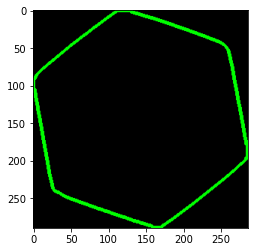

In [33]:
# Visualizing contour of template nut
cont_temp = find_contours(template_im)
im_contours_temp = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_temp, cont_temp, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

Can't receive frame (stream end?). Exiting ...
